In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!mkdir -p '/input/chest-xray-pneumonia/chest_xray'
!unzip -qq '/content/drive/MyDrive/Pertemuan 20/chest_xray.zip' -d '/input/chest-xray-pneumonia/chest_xray/'

In [4]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


# What is Pneumonia?

Pneumonia is an inflammatory condition of the lung affecting primarily the small air sacs known as alveoli.Symptoms typically include some combination of productive or dry cough, chest pain, fever and difficulty breathing. The severity of the condition is variable. Pneumonia is usually caused by infection with viruses or bacteria and less commonly by other microorganisms, certain medications or conditions such as autoimmune diseases.Risk factors include cystic fibrosis, chronic obstructive pulmonary disease (COPD), asthma, diabetes, heart failure, a history of smoking, a poor ability to cough such as following a stroke and a weak immune system. Diagnosis is often based on symptoms and physical examination. Chest X-ray, blood tests, and culture of the sputum may help confirm the diagnosis.The disease may be classified by where it was acquired, such as community- or hospital-acquired or healthcare-associated pneumonia.


In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 


# 1. Fix this error
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os


# Importing the necessary libraries

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os

Using TensorFlow backend.


# Description of the Pneumonia Dataset

The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).
Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients. All chest X-ray imaging was performed as part of patients’ routine clinical care.
For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

In [7]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

# Loading the Dataset

In [9]:
# 2. Fix this error
train = get_training_data('../input/chest-xray-pneumonia/chest_xray/chest_xray/train')
test = get_training_data('../input/chest-xray-pneumonia/chest_xray/chest_xray/test')
val = get_training_data('../input/chest-xray-pneumonia/chest_xray/chest_xray/val')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


In [14]:
print(len(train))
print(len(test))
print(len(val))

5216
624
16


# Data Visualization & Preprocessing

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


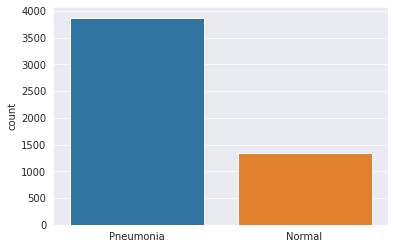

In [15]:
# 3. Fix this error
l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l)        

**The data seems imbalanced . To increase the no. of training examples, we will use data augmentation**

**Previewing the images of both the classes**

Text(0.5, 1.0, 'NORMAL')

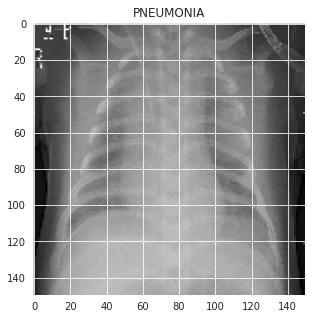

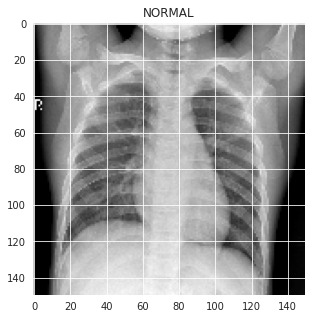

In [16]:
# 4. fix this error

plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [26]:
# 5. Please make a list that contain all features and labels for their respective purpose (train, test, val)
x_train = [x[0] for x in train]
x_test = [x[0] for x in test]
x_val = [x[0] for x in val]

y_train = [x[1] for x in train]
y_val = [x[1] for x in val]
y_test = [x[1] for x in test]

We perform a grayscale normalization to reduce the effect of illumination's differences.Moreover the CNN converges faster on [0..1] data than on [0..255].

In [27]:
#6. Please normalize the data as stated in the markdown cell
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test =  np.array(x_test) / 255

In [30]:
# resize data for deep learning 
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

# Data Augmentation

In order to avoid overfitting problem, we need to expand artificially our dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations.
Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more.
By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.

In [34]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1) 


datagen.fit(x_train)

For the data augmentation, i choosed to :
1. Randomly rotate some training images by 30 degrees 
2. Randomly Zoom by 20% some training images
3. Randomly shift images horizontally by 10% of the width 
4. Randomly shift images vertically by 10% of the height 
5. Randomly flip images horizontally.
Once our model is ready, we fit the training dataset.

# Training the Model

In [35]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 32)      320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
dropout_1 (Dropout)          (None, 75, 75, 64)        0         
_________________________________________________________________
batch_norm

In [36]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [37]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 12 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])


Epoch 1/12
163/163 [==============================] - 416s 3s/step - loss: 0.5884 - accuracy: 0.8522 - val_loss: 24.2075 - val_accuracy: 0.5000
Epoch 2/12
163/163 [==============================] - 407s 2s/step - loss: 0.1819 - accuracy: 0.9329 - val_loss: 45.1694 - val_accuracy: 0.5000
Epoch 3/12
163/163 [==============================] - 409s 3s/step - loss: 0.1547 - accuracy: 0.9496 - val_loss: 8.7173 - val_accuracy: 0.5000

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 4/12
163/163 [==============================] - 411s 3s/step - loss: 0.0817 - accuracy: 0.9724 - val_loss: 5.5711 - val_accuracy: 0.5625
Epoch 5/12
163/163 [==============================] - 411s 3s/step - loss: 0.0689 - accuracy: 0.9774 - val_loss: 6.0580 - val_accuracy: 0.5000
Epoch 6/12
163/163 [==============================] - 412s 3s/step - loss: 0.0706 - accuracy: 0.9780 - val_loss: 2.1757 - val_accuracy: 0.6250
Epoch 7/12
163/163 [==============================] - 410s

In [38]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

624/624 [==============================] - 17s 27ms/step
Loss of the model is -  1.1378533289430497
624/624 [==============================] - 17s 27ms/step
Accuracy of the model is -  82.37179517745972 %


<h1>Please create your own custom model with convolutional layer, pooling layer and fully connected layers for 5 epochs</h1>

<p>You can choose your own loss function to use but it is recommended to just use the same loss function as above, use a new variable for example myModel, etc to differentiate with the original model.</p>
<p>model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])</p>

In [41]:
# 7. please make your own custom model and train it for 5 epochs, do not forget to evaluate, (try to reach your best accuracy)
mymodel = Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape=(150,150,1)),
    BatchNormalization(),
    MaxPool2D(),
    Conv2D(32, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPool2D(),
    Conv2D(64, (3,3), padding='same', activation='relu'),
    MaxPool2D(),
    Dropout(0.25),
    BatchNormalization(),
    Conv2D(128, (3,3), activation='relu'),
    MaxPool2D(),
    BatchNormalization(),
    Conv2D(128, (3,3), padding='same', activation='relu'),
    MaxPool2D(),
    BatchNormalization(),
    Conv2D(256, (3,3), padding='same', activation='relu'),
    MaxPool2D(),
    Dropout(0.3),
    BatchNormalization(),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

In [42]:
mymodel.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
mymodel.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 148, 148, 16)      160       
_________________________________________________________________
batch_normalization_7 (Batch (None, 148, 148, 16)      64        
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
batch_normalization_8 (Batch (None, 72, 72, 32)        128       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 36, 36, 64)       

In [44]:
hist = mymodel.fit(datagen.flow(x_train, y_train, batch_size=32),
                   epochs=5,
                   validation_data=datagen.flow(x_val, y_val),
                   callbacks=[learning_rate_reduction])

Epoch 1/5
163/163 [==============================] - 208s 1s/step - loss: 0.2319 - accuracy: 0.9030 - val_loss: 3.3848 - val_accuracy: 0.5000
Epoch 2/5
163/163 [==============================] - 206s 1s/step - loss: 0.1264 - accuracy: 0.9500 - val_loss: 7.7877 - val_accuracy: 0.5000
Epoch 3/5
163/163 [==============================] - 205s 1s/step - loss: 0.1091 - accuracy: 0.9588 - val_loss: 5.3392 - val_accuracy: 0.5000

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 4/5
163/163 [==============================] - 204s 1s/step - loss: 0.0702 - accuracy: 0.9737 - val_loss: 1.9896 - val_accuracy: 0.5625
Epoch 5/5
163/163 [==============================] - 204s 1s/step - loss: 0.0702 - accuracy: 0.9724 - val_loss: 0.9032 - val_accuracy: 0.5625


# Analysis after Model Training

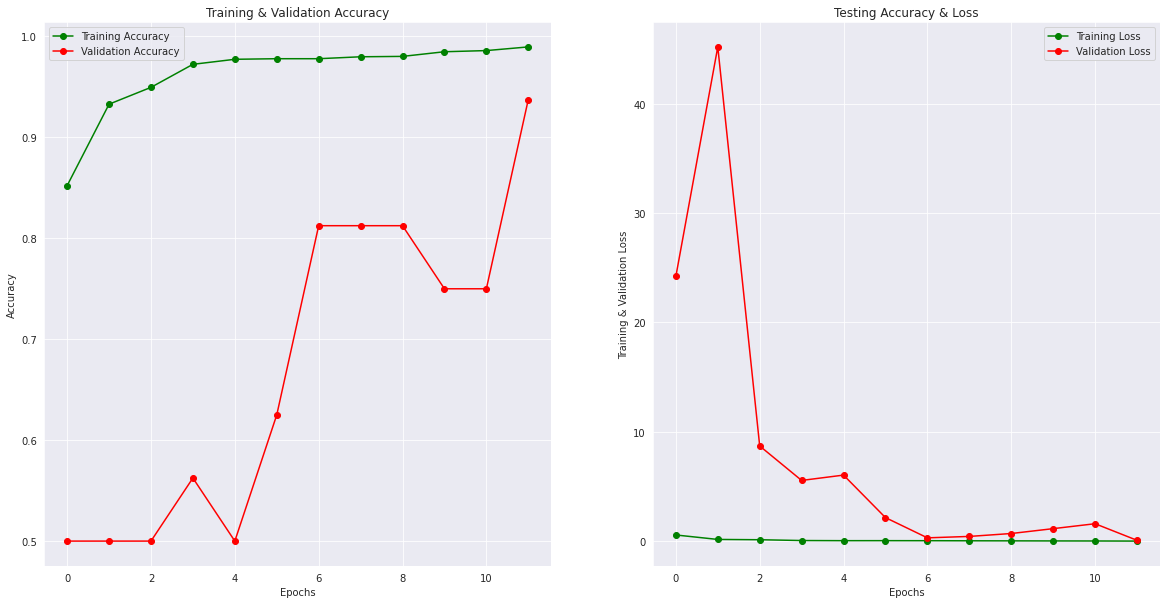

In [45]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [46]:
# 8. Please use the base model to predict on X_test

predictions = (model.predict(x_test) > 0.5).astype("int32")
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [47]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.75      0.99      0.86       390
   Normal (Class 1)       0.98      0.45      0.62       234

           accuracy                           0.79       624
          macro avg       0.87      0.72      0.74       624
       weighted avg       0.84      0.79      0.77       624



In [53]:
# 9. please make a classification report for your own model
my_y_pred = (mymodel.predict(x_test) > 0.5).astype("int32")
my_y_pred = my_y_pred.reshape(1,-1)[0]

print(classification_report(y_test, my_y_pred, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.76      1.00      0.86       390
   Normal (Class 1)       0.99      0.48      0.65       234

           accuracy                           0.80       624
          macro avg       0.88      0.74      0.75       624
       weighted avg       0.85      0.80      0.78       624



In [50]:
cm = confusion_matrix(y_test,predictions)
cm

array([[388,   2],
       [128, 106]])

In [51]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

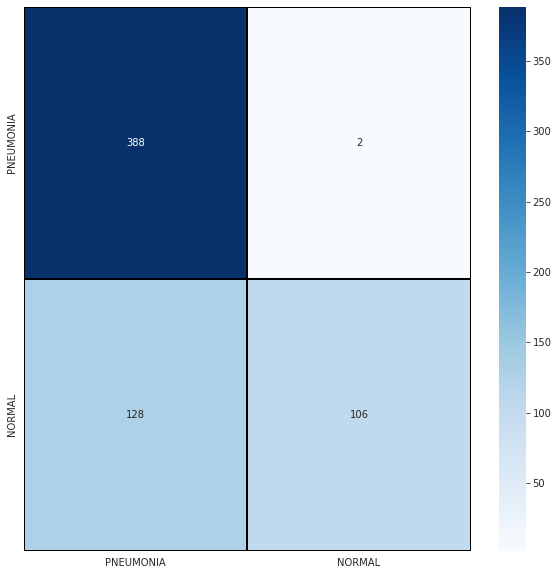

In [52]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [54]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

**Some of the Correctly Predicted Classes**

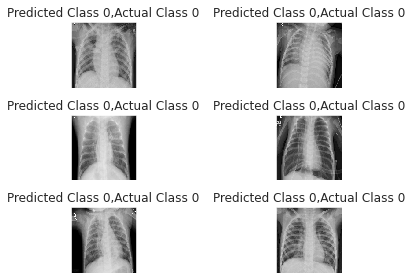

In [55]:
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

**Some of the Incorrectly Predicted Classes**

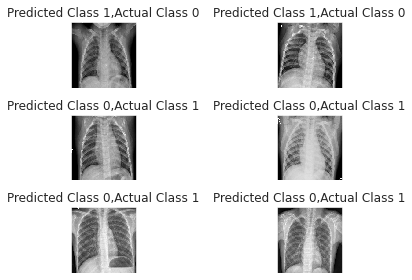

In [56]:
i = 0
for c in incorrect[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1